<a href="https://colab.research.google.com/github/bohdin/DCGAN/blob/training/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import os
import time
import tensorflow as tf

from IPython import display

In [ ]:
def make_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4 * 4 * 256, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh'))

    return model

In [ ]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
generator = make_generator()
discriminator = make_discriminator()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  gen_losses = []
  disc_losses = []

  for epoch in range(epochs):
    start = time.time()
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    num_batches = 0

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      epoch_gen_loss += gen_loss
      epoch_disc_loss += disc_loss
      num_batches += 1

    gen_losses.append(epoch_gen_loss / num_batches)
    disc_losses.append(epoch_disc_loss / num_batches)

    if (epoch + 1) % 50 == 0:
      display.clear_output(wait=True)
      generate_images(generator, epoch + 1, seed)

    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')
    print(f'Generator loss: {gen_losses[-1]}, Discriminator loss: {disc_losses[-1]}')

  display.clear_output(wait=True)
  generate_images(generator, epochs, seed)
  return gen_losses, disc_losses

In [ ]:
def generate_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img_array = (predictions[i].numpy() * 127.5 + 127.5).astype(np.uint8)
      plt.imshow(img_array)
      plt.axis('off')

  plt.show()

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

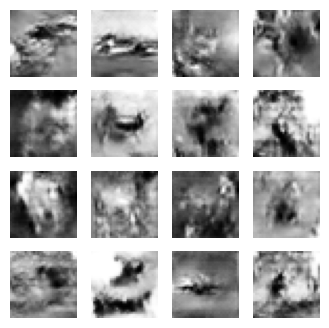

Time for epoch 650 is 10.68 sec
Generator loss: 1.2706060409545898, Discriminator loss: 1.1166572570800781
Time for epoch 651 is 10.05 sec
Generator loss: 1.232661247253418, Discriminator loss: 1.1829428672790527
Time for epoch 652 is 10.06 sec
Generator loss: 1.266649842262268, Discriminator loss: 1.0800414085388184
Time for epoch 653 is 10.05 sec
Generator loss: 1.3040473461151123, Discriminator loss: 1.0873013734817505
Time for epoch 654 is 10.09 sec
Generator loss: 1.325484275817871, Discriminator loss: 1.1310287714004517
Time for epoch 655 is 10.09 sec
Generator loss: 1.3308440446853638, Discriminator loss: 1.111993432044983
Time for epoch 656 is 10.04 sec
Generator loss: 1.320266604423523, Discriminator loss: 1.0998203754425049
Time for epoch 657 is 10.05 sec
Generator loss: 1.2890405654907227, Discriminator loss: 1.129492163658142


KeyboardInterrupt: 

In [ ]:
gen_history, dis_history = train(train_dataset, EPOCHS)

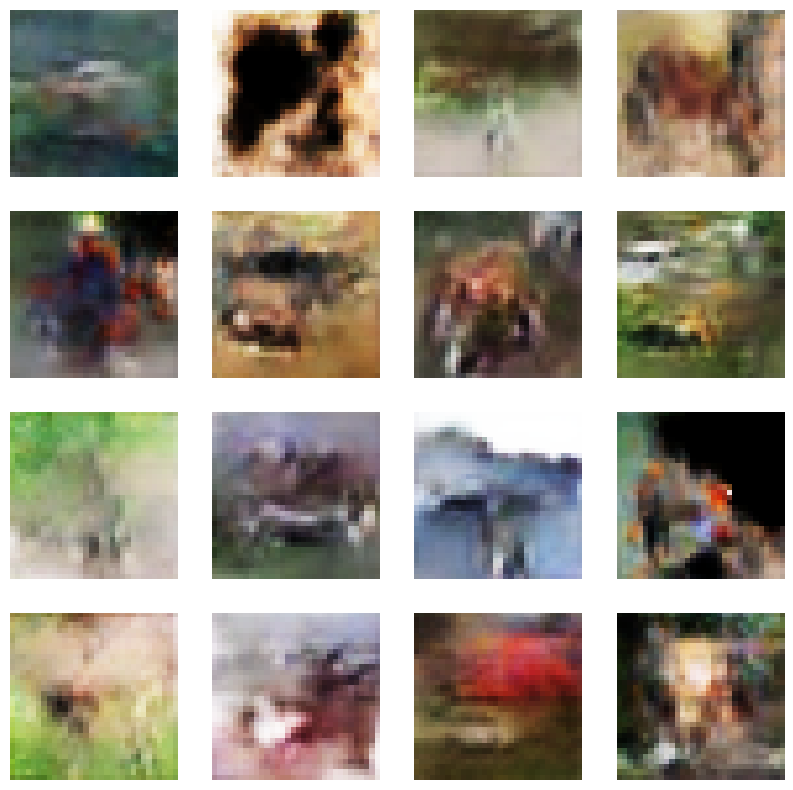

In [ ]:
predictions = generator(seed, training=False)

plt.figure(figsize=(10, 10))
for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    img_array = (predictions[i].numpy() * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(img_array)
    plt.axis('off')
plt.show()

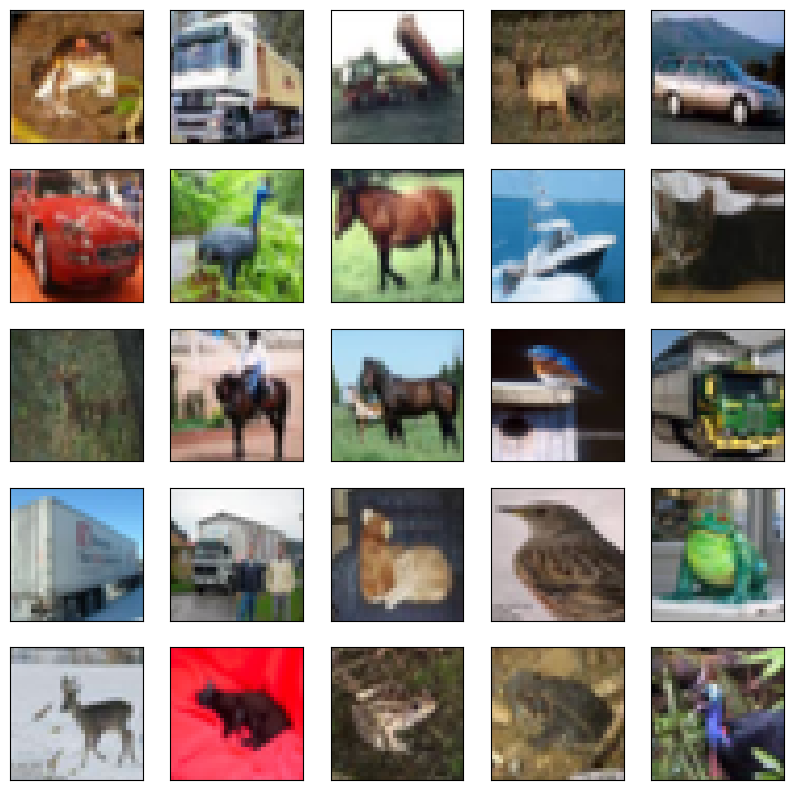

In [ ]:
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()